# 2017 LANL Unified Host and Network Data Analysis Notebook

2017 LANL Unified Host and Network data set:
https://csr.lanl.gov/data/2017.html

The focus of this Notebook will be on WinEvents vs Netflow (at least to start)

In [3]:
# (Optional) Install less common python lib:
# !pip install wget

In [56]:
# Required libraries
import os
import wget  # used for downloading the data
import pandas as pd
import numpy as np
import myLib as ml  # supporting lib
#import random as rd
import matplotlib.pyplot as plt
#import datetime
#from io import StringIO
#from IPython.display import display as disp
#from IPython.display import Markdown as md
#from IPython.display import Latex as lt
plt.style.use(['seaborn'])

## Set the day(s) to investigate

In [5]:
# Days available 1-90
day = "03"  # TODO: support looping through to process/build model from multiple days
# Because of data size I'm limiting to a single day for my laptop

# Filenames to work with
NF_filename = f"./data/netflow_day-{day}"
WE_filename = f"./data/wls_day-{day}"

## Download the data (optional)

In [6]:
if not os.path.exists('./data'):
    os.makedirs('./data')

# Paths to LANL 2017 Netflow and WinEvents data set
NF_url = f"https://s3-us-gov-west-1.amazonaws.com/unified-host-network-dataset/2017/netflow/netflow_day-{day}.bz2"
WE_url = f"https://s3-us-gov-west-1.amazonaws.com/unified-host-network-dataset/2017/wls/wls_day-{day}.bz2"

wget.download(NF_url, out=f"{NF_filename}.bz2")
wget.download(WE_url, out=f"{WE_filename}.bz2")

!bzip2 -dk "{NF_filename}.bz2"
!bzip2 -dk "{WE_filename}.bz2"

## Explore and sample the WinEvents data

In [8]:
# Display number of records
n_lines_WE = ml.file_len(WE_filename)
n_lines_NF = ml.file_len(NF_filename)

pd.DataFrame([[n_lines_NF,n_lines_WE]],columns=["NetFlow_Lines","WinEvent_Lines"],index=[f'Day{day}'])

,NetFlow_Lines,WinEvent_Lines
Day03,201214609,66352868


In [9]:
# Focus on building a model from 10% of the WinEvents
n_samples = round(0.1*n_lines_WE)
print(f"Number of WinEvent records in samples: {n_samples}")
WE_sample = pd.DataFrame.from_dict(ml.dict_random_sampler(WE_filename, n_lines_WE, n_samples))

Number of WinEvent records in samples: 6635287


In [10]:
# Initial view of data values
WE_sample.head()

,AuthenticationPackage,Destination,DomainName,EventID,FailureReason,LogHost,LogonID,LogonType,LogonTypeDescription,ParentProcessID,...,ProcessID,ProcessName,ServiceName,Source,Status,SubjectDomainName,SubjectLogonID,SubjectUserName,Time,UserName
0,Negotiate,NaN,nt authority,4624,NaN,Comp531955,0x3e7,5.0,Service,NaN,...,0x2e0,services.exe,NaN,NaN,NaN,NaN,NaN,NaN,172800,system
1,Kerberos,NaN,Domain001,4624,NaN,ActiveDirectory,0x3483146a,3.0,Network,NaN,...,NaN,NaN,NaN,Comp432007,NaN,NaN,NaN,NaN,172800,Comp432007$
2,Kerberos,NaN,Domain001,4624,NaN,ActiveDirectory,0x34831730,3.0,Network,NaN,...,NaN,NaN,NaN,Comp916832,NaN,NaN,NaN,NaN,172800,Comp916832$
3,NaN,NaN,Domain001,4634,NaN,ActiveDirectory,0x34831730,3.0,Network,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,172800,Comp916832$
4,NaN,NaN,Domain001,4768,NaN,ActiveDirectory,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,EnterpriseAppServer,0x0,NaN,NaN,NaN,172800,AppService


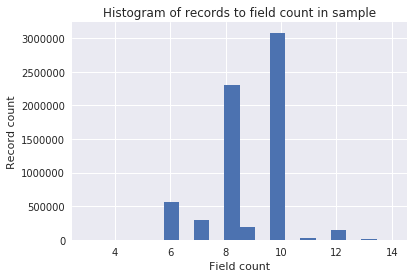

In [11]:
# Histogram of values per record - as we saw there are several NaNs per record
ax1=plt.subplot(1,1,1)
plt.title('Histogram of records to field count in sample')
plt.ylabel('Record count')
plt.xlabel('Field count')
disp(_=WE_sample.count(axis=1).hist(bins=20))

In [12]:
# Here are the common non-NaN columns
WE_sample.head().dropna(axis=1)

,DomainName,EventID,LogHost,Time,UserName
0,nt authority,4624,Comp531955,172800,system
1,Domain001,4624,ActiveDirectory,172800,Comp432007$
2,Domain001,4624,ActiveDirectory,172800,Comp916832$
3,Domain001,4634,ActiveDirectory,172800,Comp916832$
4,Domain001,4768,ActiveDirectory,172800,AppService


In [13]:
# Columns in WinEvents
list(WE_sample)

['AuthenticationPackage',
 'Destination',
 'DomainName',
 'EventID',
 'FailureReason',
 'LogHost',
 'LogonID',
 'LogonType',
 'LogonTypeDescription',
 'ParentProcessID',
 'ParentProcessName',
 'ProcessID',
 'ProcessName',
 'ServiceName',
 'Source',
 'Status',
 'SubjectDomainName',
 'SubjectLogonID',
 'SubjectUserName',
 'Time',
 'UserName']

## Output sampled WinEvents to CSV for future use

In [24]:
WE_sample.to_csv(f'./data/WE_D{day}_sampled.csv')

## Read CSV version of sampled WinEvents (optional)

In [44]:
WE_sample = pd.read_csv(f'./data/WE_D{day}_sampled.csv')

## Feature Engineering

In [45]:
#for col in list(WE_sample):
#    WE_sample[col].hist()

WE_unique = ml.categorical_checker(WE_sample)

,AuthenticationPackage,Destination,DomainName,EventID,FailureReason,LogHost,LogonType,LogonTypeDescription,ParentProcessID,ParentProcessName,ProcessID,ProcessName,ServiceName,Source,Status,SubjectDomainName,SubjectLogonID,SubjectUserName,Time,UserName
DataType,object,object,object,int64,object,object,float64,object,object,object,object,object,object,object,object,object,object,object,int64,object
Unique,5,3087,263,19,7,10152,10,10,13343,1328,32659,2982,9204,11610,8,55,2102,7426,86396,20564
Total,2367828,104298,6634920,6635287,26116,6635287,3391273,3391273,1643250,1643250,1853935,1853935,205234,2198400,914195,107312,105596,107312,6635287,6634954
Percent,2.11164e-06,0.0295979,3.96388e-05,2.86348e-06,0.000268035,0.00153,2.94875e-06,2.94875e-06,0.00811988,0.000808155,0.017616,0.00160847,0.0448464,0.00528111,8.75087e-06,0.000512524,0.0199061,0.0692001,0.0130207,0.00309934


In [46]:
# Look into the distribution of the types of authentication
WE_sample.groupby(['AuthenticationPackage']).size()

AuthenticationPackage
-                                            168
Kerberos                                 1347790
MICROSOFT_AUTHENTICATION_PACKAGE_V1_0     645460
NTLM                                      310950
Negotiate                                  63460
dtype: int64

In [47]:
# Look into the distribution of the types of Failures
WE_sample.groupby(['FailureReason']).size()

FailureReason
Account currently disabled.                                                   66
Account locked out.                                                         1527
An Error occured during Logon.                                             10541
The NetLogon component is not active.                                         11
The specified account's password has expired.                               4212
The user has not been granted the requested logon type at this machine.      896
Unknown user name or bad password.                                          8863
dtype: int64

In [48]:
# Look into the distribution of LogonTypeDescription
WE_sample.groupby(['LogonTypeDescription']).size()

LogonTypeDescription
Batch                    451
CachedInteractive        130
Interactive            28781
Local System             168
Network              3303673
NetworkClearText       11216
NewCredentials          2589
RemoteInteractive        327
Service                25346
Unlock                 18592
dtype: int64

In [49]:
# Look into the distribution of Status
WE_sample.groupby(['Status']).size()

Status
0x0           830524
0xc0000064     32208
0xc000006a     13158
0xc000006e         7
0xc0000072       918
0xc0000199       160
0xc0000224         1
0xc0000234     37219
dtype: int64

From http://errorco.de/win32/ntstatus-h/

| Status Code | Description |
| ----------- | ----------- |
| 0xc000006e | Indicates a referenced user name and authentication information are valid, but some user account restriction has prevented successful authentication (such as time-of-day restrictions).
| 0xc0000224 | The user's password must be changed before signing in.
| 0xc0000199 | The account used is a Computer Account. Use your global user account or local user account to access this server.
| 0xc0000072 | The referenced account is currently disabled and may not be logged on to.
| 0xc000006a | When trying to update a password, this return status indicates that the value provided as the current password is not correct.
| 0xc0000064 | The specified account does not exist.
| 0xc0000234 |The user account has been automatically locked because too many invalid logon attempts or password change attempts have been requested.

There are some potentially interesting status values here.

In [50]:
# Convert features to categorical
WE_cat=['AuthenticationPackage','FailureReason','LogonTypeDescription','Status']
WE_sample[WE_cat] = WE_sample[WE_cat].astype('category')

In [51]:
# Time Bins
start_time = (int(day)-1)*60*60*24
WE_sample["minute"] = (WE_sample.Time-start_time)//60
WE_sample["5_minutes"] = (WE_sample.Time-start_time)//300
WE_sample["30_minutes"] = (WE_sample.Time-start_time)//1800
WE_sample["hour"] = (WE_sample.Time-start_time)//3600

# Add Event Descriptions
WE_types = pd.read_csv('./data/WinEventTypes.csv')
WE_types.Description = WE_types.Description.astype('category')
WE_sample = pd.merge(WE_sample, WE_types, how='left', left_on='EventID', right_on='EventID')

# System Labels
WE_sample["recorded_by"] = WE_sample.LogHost.str.replace('\d+','').astype('category')  # either a computer, active directory, or app server

WE_sample.head()

,Unnamed: 0,AuthenticationPackage,Destination,DomainName,EventID,FailureReason,LogHost,LogonID,LogonType,LogonTypeDescription,ParentProcessID,ParentProcessName,ProcessID,ProcessName,ServiceName,Source,Status,SubjectDomainName,SubjectLogonID,SubjectUserName,Time,UserName,minute,5_minutes,30_minutes,hour,Description,recorded_by
0,0,Negotiate,NaN,nt authority,4624,NaN,Comp531955,0x3e7,5.0,Service,NaN,NaN,0x2e0,services.exe,NaN,NaN,NaN,NaN,NaN,NaN,172800,system,0,0,0,0,An account was successfully logged on,Comp
1,1,Kerberos,NaN,Domain001,4624,NaN,ActiveDirectory,0x3483146a,3.0,Network,NaN,NaN,NaN,NaN,NaN,Comp432007,NaN,NaN,NaN,NaN,172800,Comp432007$,0,0,0,0,An account was successfully logged on,ActiveDirectory
2,2,Kerberos,NaN,Domain001,4624,NaN,ActiveDirectory,0x34831730,3.0,Network,NaN,NaN,NaN,NaN,NaN,Comp916832,NaN,NaN,NaN,NaN,172800,Comp916832$,0,0,0,0,An account was successfully logged on,ActiveDirectory
3,3,NaN,NaN,Domain001,4634,NaN,ActiveDirectory,0x34831730,3.0,Network,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,172800,Comp916832$,0,0,0,0,An account was logged on,ActiveDirectory
4,4,NaN,NaN,Domain001,4768,NaN,ActiveDirectory,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EnterpriseAppServer,0x0,NaN,NaN,NaN,172800,AppService,0,0,0,0,Kerberos authentication ticket was requested (...,ActiveDirectory


In [52]:
# Look into the distribution of recorded_by
WE_sample.groupby(['recorded_by']).size()

recorded_by
ActiveDirectory        2463692
Comp                   3764853
EnterpriseAppServer     406742
dtype: int64

### Histogram of Events over time

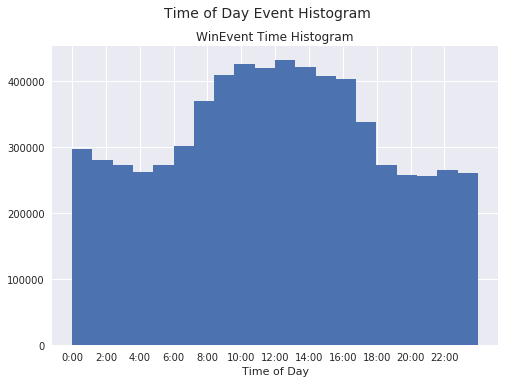

In [60]:
ax1=plt.subplot(1,1,1)
plt.title('WinEvent Time Histogram')
plt.xlabel('Time of Day')
ax1.set_xticks(60*np.arange(0,24,2))
ax1.set_xticklabels([f'{x}:00' for x in np.arange(0,24,)])
_=WE_sample.minute.hist(bins=20)

plt.suptitle('Time of Day Event Histogram',fontsize=14)
plt.show()

* "After Hours" appears to be between hours 0-7 and 17-24

### After Hours feature

In [63]:
WE_sample["after_hours"] = ((WE_sample["hour"] < 7) | (WE_sample["hour"] > 17))
WE_sample.groupby(['after_hours']).size()

after_hours
False    3686914
True     2948373
dtype: int64

### Event Id 4608 - Windows is starting up

In [110]:
WE_sample["time_since_startup"] = np.NaN
time_dict = {}

def find_startup_time(row):
    if row.EventID==4608:
        time_dict[row.LogHost]=row.Time
        return row.Time
    else:
        if row.LogHost in time_dict:
            return (row.Time - time_dict[row.LogHost]) # Primary: key event off LogHost
        elif row.Source in time_dict:
            return (row.Time - time_dict[row.Source])  # Secondary: key event off Source
        elif isinstance(row.UserName, str):
            if row.UserName[:-1] in time_dict:
                return (row.Time - time_dict[row.UserName[:-1]])  # Tertiary: key event off Username
        else:
            return np.NaN  # Otherwise call the event not related to any previous startup event

In [111]:
%%time
# Create new feature based on time since LogHost started up
WE_sample["time_since_startup"] = WE_sample.apply(find_startup_time, axis=1)

CPU times: user 11min 58s, sys: 16.2 s, total: 12min 14s
Wall time: 12min 19s


In [112]:
# Do a quick check to make sure the above worked
WE_sample[WE_sample["LogHost"]=="EnterpriseAppServer"].tail(10)

,Unnamed: 0,AuthenticationPackage,Destination,DomainName,EventID,FailureReason,LogHost,LogonID,LogonType,LogonTypeDescription,ParentProcessID,ParentProcessName,ProcessID,ProcessName,ServiceName,Source,Status,SubjectDomainName,SubjectLogonID,SubjectUserName,Time,UserName,minute,5_minutes,30_minutes,hour,Description,recorded_by,after_hours,time_since_startup
6635090,6635090,NaN,NaN,Domain001,4634,NaN,EnterpriseAppServer,0xb9f6266,3.0,Network,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,259197,Administrator,1439,287,47,23,An account was logged on,EnterpriseAppServer,True,32732.0
6635091,6635091,NaN,NaN,Domain001,4634,NaN,EnterpriseAppServer,0xb88fb60,3.0,Network,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,259197,Administrator,1439,287,47,23,An account was logged on,EnterpriseAppServer,True,32732.0
6635166,6635166,Kerberos,NaN,Domain001,4624,NaN,EnterpriseAppServer,0x10050e01,3.0,Network,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,259198,User793535,1439,287,47,23,An account was successfully logged on,EnterpriseAppServer,True,32733.0
6635168,6635168,Kerberos,NaN,Domain001,4624,NaN,EnterpriseAppServer,0xb8bad02,3.0,Network,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,259198,AppService,1439,287,47,23,An account was successfully logged on,EnterpriseAppServer,True,32733.0
6635197,6635197,Kerberos,NaN,Domain001,4624,NaN,EnterpriseAppServer,0xba44b36,3.0,Network,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,259199,User553543,1439,287,47,23,An account was successfully logged on,EnterpriseAppServer,True,32734.0
6635204,6635204,NaN,NaN,Domain001,4634,NaN,EnterpriseAppServer,0x138854f9,3.0,Network,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,259199,AppService,1439,287,47,23,An account was logged on,EnterpriseAppServer,True,32734.0
6635260,6635260,Kerberos,NaN,Domain001,4624,NaN,EnterpriseAppServer,0x100511b5,3.0,Network,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,259199,User793535,1439,287,47,23,An account was successfully logged on,EnterpriseAppServer,True,32734.0
6635269,6635269,MICROSOFT_AUTHENTICATION_PACKAGE_V1_0,NaN,Domain002,4776,NaN,EnterpriseAppServer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EnterpriseAppServer,0x0,NaN,NaN,NaN,259199,AppService,1439,287,47,23,The domain controller attempted to validate th...,EnterpriseAppServer,True,32734.0
6635270,6635270,NaN,NaN,EnterpriseAppServer,4672,NaN,EnterpriseAppServer,0x17682008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,259199,AppService,1439,287,47,23,Special privileges assigned to a new logon,EnterpriseAppServer,True,32734.0
6635271,6635271,NaN,NaN,EnterpriseAppServer,4672,NaN,EnterpriseAppServer,0x17682032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,259199,AppService,1439,287,47,23,Special privileges assigned to a new logon,EnterpriseAppServer,True,32734.0


In [113]:
near_startup_threshold = 60 # Estimated 60s to be considered part of the startup event
WE_sample["near_startup"] = (WE_sample["time_since_startup"] <= near_startup_threshold)
WE_sample.groupby(["near_startup"]).size()

near_startup
False    6628896
True        6391
dtype: int64

### Event Id 4800 - The workstation was locked (4801 unlocks)

In [114]:
WE_sample["time_since_locked"] = np.NaN
time_dict = {}

def check_lock_state(row):
    if row.EventID == 4800:  # Locked
        time_dict[row.LogHost]=row.Time
        return row.Time
    elif row.EventID == 4801:  # Unlocked
        time_dict.pop(row.LogHost, None)
    else:  # Still possibly locked
        if row.LogHost in time_dict:
            return (row.Time - time_dict[row.LogHost]) # Primary: key event off LogHost
        elif row.Source in time_dict:
            return (row.Time - time_dict[row.Source])  # Secondary: key event off Source
        elif isinstance(row.UserName, str):
            if row.UserName[:-1] in time_dict:
                return (row.Time - time_dict[row.UserName[:-1]])  # Tertiary: key event off Username
        else:
            return np.NaN  # Otherwise call the event not related to any previous startup event

In [115]:
%%time
# Create new feature based on time since LogHost locked
WE_sample["time_since_locked"] = WE_sample.apply(check_lock_state, axis=1)

CPU times: user 12min 40s, sys: 8.52 s, total: 12min 48s
Wall time: 12min 48s


In [116]:
# Do a quick check to make sure the above worked
WE_sample[WE_sample["LogHost"]=="EnterpriseAppServer"].tail(10)

,Unnamed: 0,AuthenticationPackage,Destination,DomainName,EventID,FailureReason,LogHost,LogonID,LogonType,LogonTypeDescription,ParentProcessID,ParentProcessName,ProcessID,ProcessName,ServiceName,Source,Status,SubjectDomainName,SubjectLogonID,SubjectUserName,Time,UserName,minute,5_minutes,30_minutes,hour,Description,recorded_by,after_hours,time_since_startup,near_startup,time_since_locked
6635090,6635090,NaN,NaN,Domain001,4634,NaN,EnterpriseAppServer,0xb9f6266,3.0,Network,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,259197,Administrator,1439,287,47,23,An account was logged on,EnterpriseAppServer,True,32732.0,False,16287.0
6635091,6635091,NaN,NaN,Domain001,4634,NaN,EnterpriseAppServer,0xb88fb60,3.0,Network,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,259197,Administrator,1439,287,47,23,An account was logged on,EnterpriseAppServer,True,32732.0,False,16287.0
6635166,6635166,Kerberos,NaN,Domain001,4624,NaN,EnterpriseAppServer,0x10050e01,3.0,Network,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,259198,User793535,1439,287,47,23,An account was successfully logged on,EnterpriseAppServer,True,32733.0,False,16288.0
6635168,6635168,Kerberos,NaN,Domain001,4624,NaN,EnterpriseAppServer,0xb8bad02,3.0,Network,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,259198,AppService,1439,287,47,23,An account was successfully logged on,EnterpriseAppServer,True,32733.0,False,16288.0
6635197,6635197,Kerberos,NaN,Domain001,4624,NaN,EnterpriseAppServer,0xba44b36,3.0,Network,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,259199,User553543,1439,287,47,23,An account was successfully logged on,EnterpriseAppServer,True,32734.0,False,16289.0
6635204,6635204,NaN,NaN,Domain001,4634,NaN,EnterpriseAppServer,0x138854f9,3.0,Network,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,259199,AppService,1439,287,47,23,An account was logged on,EnterpriseAppServer,True,32734.0,False,16289.0
6635260,6635260,Kerberos,NaN,Domain001,4624,NaN,EnterpriseAppServer,0x100511b5,3.0,Network,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,259199,User793535,1439,287,47,23,An account was successfully logged on,EnterpriseAppServer,True,32734.0,False,16289.0
6635269,6635269,MICROSOFT_AUTHENTICATION_PACKAGE_V1_0,NaN,Domain002,4776,NaN,EnterpriseAppServer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EnterpriseAppServer,0x0,NaN,NaN,NaN,259199,AppService,1439,287,47,23,The domain controller attempted to validate th...,EnterpriseAppServer,True,32734.0,False,16289.0
6635270,6635270,NaN,NaN,EnterpriseAppServer,4672,NaN,EnterpriseAppServer,0x17682008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,259199,AppService,1439,287,47,23,Special privileges assigned to a new logon,EnterpriseAppServer,True,32734.0,False,16289.0
6635271,6635271,NaN,NaN,EnterpriseAppServer,4672,NaN,EnterpriseAppServer,0x17682032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,259199,AppService,1439,287,47,23,Special privileges assigned to a new logon,EnterpriseAppServer,True,32734.0,False,16289.0


In [117]:
WE_sample["is_locked"] = (WE_sample["time_since_locked"] > 0)
WE_sample.groupby(["is_locked"]).size()

is_locked
False    4760629
True     1874658
dtype: int64

### Event Id 4802 - The screensaver was invoked (4803 dismisses screensaver)

In [118]:
WE_sample["time_since_screensaver"] = np.NaN
time_dict = {}

def check_screensaver_state(row):
    if row.EventID == 4802:  # Screensaver active
        time_dict[row.LogHost]=row.Time
        return row.Time
    elif row.EventID == 4803:  # Screensaver deactivated
        time_dict.pop(row.LogHost, None)
    else:  # Still possibly locked
        if row.LogHost in time_dict:
            return (row.Time - time_dict[row.LogHost]) # Primary: key event off LogHost
        elif row.Source in time_dict:
            return (row.Time - time_dict[row.Source])  # Secondary: key event off Source
        elif isinstance(row.UserName, str):
            if row.UserName[:-1] in time_dict:
                return (row.Time - time_dict[row.UserName[:-1]])  # Tertiary: key event off Username
        else:
            return np.NaN  # Otherwise call the event not related to any previous startup event

In [119]:
%%time
# Create new feature based on time since LogHost screensaver
WE_sample["time_since_screensaver"] = WE_sample.apply(check_screensaver_state, axis=1)

CPU times: user 13min 10s, sys: 9.17 s, total: 13min 19s
Wall time: 13min 19s


In [121]:
# Do a quick check to make sure the above worked
WE_sample.tail(10)

,Unnamed: 0,AuthenticationPackage,Destination,DomainName,EventID,FailureReason,LogHost,LogonID,LogonType,LogonTypeDescription,ParentProcessID,ParentProcessName,ProcessID,ProcessName,ServiceName,Source,Status,SubjectDomainName,SubjectLogonID,SubjectUserName,Time,UserName,minute,5_minutes,30_minutes,hour,Description,recorded_by,after_hours,time_since_startup,near_startup,time_since_locked,is_locked,time_since_screensaver
6635277,6635277,NaN,NaN,Domain001,4769,NaN,ActiveDirectory,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EnterpriseAppServer$,EnterpriseAppServer,0x0,NaN,NaN,NaN,259199,AppService,1439,287,47,23,Kerberos service ticket was requested (TGS),ActiveDirectory,True,32734.0,False,51970.0,True,NaN
6635278,6635278,Kerberos,NaN,Domain001,4624,NaN,ActiveDirectory,0x6952efcb,3.0,Network,NaN,NaN,NaN,NaN,NaN,Comp792408,NaN,NaN,NaN,NaN,259199,Comp792408$,1439,287,47,23,An account was successfully logged on,ActiveDirectory,True,NaN,False,51970.0,True,NaN
6635279,6635279,MICROSOFT_AUTHENTICATION_PACKAGE_V1_0,NaN,Domain001,4776,NaN,ActiveDirectory,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comp807801,0x0,NaN,NaN,NaN,259199,AppService,1439,287,47,23,The domain controller attempted to validate th...,ActiveDirectory,True,NaN,False,51970.0,True,NaN
6635280,6635280,NaN,NaN,Domain001,4634,NaN,ActiveDirectory,0x3d6e7c7d,3.0,Network,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,259199,Comp698877$,1439,287,47,23,An account was logged on,ActiveDirectory,True,NaN,False,51970.0,True,NaN
6635281,6635281,NaN,NaN,Domain001,4688,NaN,Comp403367,0x3e7,NaN,NaN,0x350,svchost,0x6cc4,dllhost.exe,NaN,NaN,NaN,NaN,NaN,NaN,259199,Comp403367$,1439,287,47,23,Process start,Comp,True,NaN,False,36921.0,True,NaN
6635282,6635282,MICROSOFT_AUTHENTICATION_PACKAGE_V1_0,NaN,Domain001,4776,NaN,ActiveDirectory,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comp367857,0x0,NaN,NaN,NaN,259199,AppService,1439,287,47,23,The domain controller attempted to validate th...,ActiveDirectory,True,NaN,False,51970.0,True,NaN
6635283,6635283,Kerberos,NaN,Domain001,4624,NaN,ActiveDirectory,0x3d6ed14b,3.0,Network,NaN,NaN,NaN,NaN,NaN,Comp594797,NaN,NaN,NaN,NaN,259199,User883198,1439,287,47,23,An account was successfully logged on,ActiveDirectory,True,NaN,False,51970.0,True,NaN
6635284,6635284,NaN,NaN,Domain001,4769,NaN,ActiveDirectory,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comp916004$,Comp916004,0x0,NaN,NaN,NaN,259199,User959821,1439,287,47,23,Kerberos service ticket was requested (TGS),ActiveDirectory,True,NaN,False,51970.0,True,NaN
6635285,6635285,NaN,NaN,Domain001,4688,NaN,Comp520679,0x3e7,NaN,NaN,0x31c,services,0x9b0,Proc612297.exe,NaN,NaN,NaN,NaN,NaN,NaN,259199,Comp520679$,1439,287,47,23,Process start,Comp,True,NaN,False,NaN,False,NaN
6635286,6635286,NaN,NaN,Domain001,4688,NaN,Comp236461,0x3e7,NaN,NaN,0x29c,services,0xbec0,rundll32.exe,NaN,NaN,NaN,NaN,NaN,NaN,259199,Comp236461$,1439,287,47,23,Process start,Comp,True,NaN,False,NaN,False,NaN


In [122]:
WE_sample["is_screensaver"] = (WE_sample["time_since_screensaver"] > 0)
WE_sample.groupby(["is_screensaver"]).size()

is_screensaver
False    6506929
True      128358
dtype: int64

### UserName Type feature

In [126]:
WE_sample["UserName_type"] = np.NaN

import re
comp_re = re.compile('Comp\d+\$')
user_re = re.compile('User\d+')

def check_username_type(row):
    if isinstance(row.UserName, str):
        if comp_re.match(row.UserName):
            return "Computer account"
        elif user_re.match(row.UserName):
            return "User account"
    return row.UserName

WE_sample["UserName_type"] = WE_sample.apply(check_username_type, axis=1)
WE_sample.groupby(["UserName_type"]).size()

UserName_type
ActiveDirectory$          84762
Administrator            304138
Anonymous                 53380
AppService               397882
Computer account        3322490
EnterpriseAppServer$      59662
Scanner                  411120
User account            1917339
local service             28784
network service             291
system                    50116
winservice                 4990
dtype: int64

### Has ParentProcess

In [137]:
WE_sample["has_parent_process"] = np.NaN

WE_sample["has_parent_process"] = (pd.notna(WE_sample["ParentProcessName"]))
WE_sample.groupby(["has_parent_process"]).size()

has_parent_process
False    4992037
True     1643250
dtype: int64

### TODO: add feature of count of distinct hosts or users running a process and/or parentprocess

* And count of distinct parent processes for a process
* Avg count of times process run within 24hr period 
etc.

### Explore processes that are started with after_hours, is_locked, is_screensaver, near_startup features

In [138]:
proc_df = WE_sample[WE_sample["EventID"] == 4688][["recorded_by","ParentProcessName","ProcessName","has_parent_process","UserName_type","after_hours","near_startup","is_locked","is_screensaver"]]
proc_df.head()

,recorded_by,ParentProcessName,ProcessName,has_parent_process,UserName_type,after_hours,near_startup,is_locked,is_screensaver
8,Comp,services,vssvc.exe,True,Computer account,True,False,False,False
10,Comp,services,rundll32.exe,True,Computer account,True,False,False,False
11,Comp,services,rundll32.exe,True,Computer account,True,False,False,False
12,Comp,taskeng,Proc318985.exe,True,Computer account,True,False,False,False
13,Comp,services,rundll32.exe,True,Computer account,True,False,False,False


In [140]:
# Convert booleans to 0 and 1
proc_df["after_hours"] = proc_df["after_hours"].astype('int')
proc_df["near_startup"] = proc_df["near_startup"].astype('int')
proc_df["is_locked"] = proc_df["is_locked"].astype('int')
proc_df["is_screensaver"] = proc_df["is_screensaver"].astype('int')
proc_df["has_parent_process"] = proc_df["has_parent_process"].astype('int')

# One-Hot Encode recorded_by and UserName_type
proc_df["recorded_by"] = proc_df["recorded_by"].astype('category')
proc_df = pd.concat([proc_df,pd.get_dummies(proc_df["recorded_by"], prefix="recorded_by")], axis=1)
proc_df.drop(["recorded_by"],axis=1, inplace=True)
proc_df["UserName_type"] = proc_df["UserName_type"].astype('category')
proc_df = pd.concat([proc_df,pd.get_dummies(proc_df["UserName_type"], prefix="UserName_type")], axis=1)
proc_df.drop(["UserName_type"],axis=1, inplace=True)

proc_df.head(10)

,ParentProcessName,ProcessName,has_parent_process,after_hours,near_startup,is_locked,is_screensaver,recorded_by_ActiveDirectory,recorded_by_Comp,recorded_by_EnterpriseAppServer,UserName_type_ActiveDirectory$,UserName_type_Administrator,UserName_type_AppService,UserName_type_Computer account,UserName_type_EnterpriseAppServer$,UserName_type_Scanner,UserName_type_User account,UserName_type_local service,UserName_type_winservice
8,services,vssvc.exe,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
10,services,rundll32.exe,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
11,services,rundll32.exe,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
12,taskeng,Proc318985.exe,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
13,services,rundll32.exe,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
15,services,svchost.exe,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
16,Proc443607,searchfilterhost.exe,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
18,csrss,conhost.exe,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
20,services,rundll32.exe,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
26,services,svchost.exe,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0


In [141]:

proc_df_labels = proc_df[["ParentProcessName", "ProcessName"]]
proc_df.drop(["ParentProcessName"],axis=1, inplace=True)
proc_df.drop(["ProcessName"],axis=1, inplace=True)

# Apply PCA to the data.
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(proc_df)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [142]:
# Investigate the variance accounted for by each principal component.
print("Components: ", pca.components_)
print("Variance: ", pca.explained_variance_)
print("Ratio: ", pca.explained_variance_ratio_)
print("Singular: ", pca.singular_values_)

Components:  [[-1.36900085e-02 -9.57845921e-01  4.45479003e-03  5.03643692e-02
   7.21857207e-03  7.33369226e-05 -2.80110985e-02  2.79377616e-02
   7.26320763e-05  2.51451618e-04  5.88932761e-03 -2.16000894e-01
   1.45756647e-02  1.73054690e-04  1.75770197e-01  1.92698083e-02
  -1.24181884e-06]
 [ 4.45355424e-03  2.79782113e-01  4.12267562e-04  8.35947491e-02
  -2.06144216e-03  9.72890174e-04 -2.12102392e-01  2.11129502e-01
   8.82641900e-04  5.44958273e-04  2.27613709e-02 -7.39126935e-01
   1.29432991e-01  1.26078085e-03  5.05314957e-01  7.88677107e-02
   6.15242300e-05]
 [ 4.69350526e-03  2.19870218e-02 -3.30026356e-03  9.89990314e-01
   8.31695982e-02  8.86544937e-04 -1.26730143e-02  1.17864694e-02
   8.17565459e-04 -3.49948713e-04 -2.10847739e-03  7.24769471e-02
   9.69775153e-03 -2.44289804e-04 -8.26303758e-02  2.30278431e-03
   3.80432772e-05]
 [ 1.67994887e-03 -5.90383843e-02 -1.25277491e-03 -5.64315937e-02
  -3.18409809e-02  1.21983734e-03 -5.32731442e-01  5.31511605e-01
   1.1

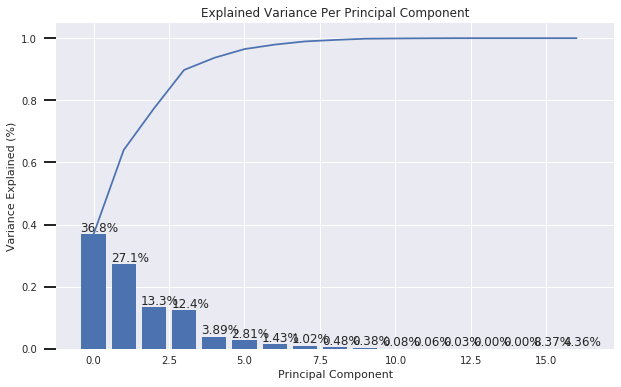

In [143]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    

scree_plot(pca)

Text(0, 0.5, 'Value Gain')

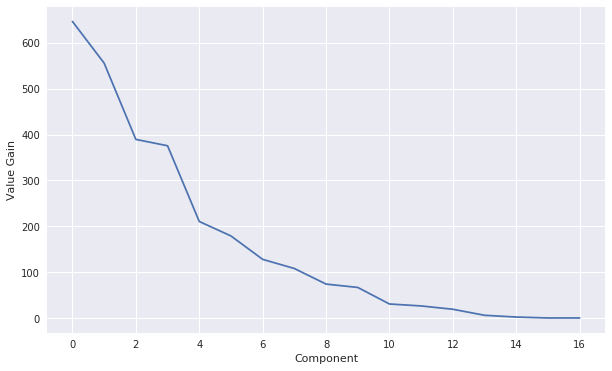

In [144]:
# Taking another view from the singular value decomposition
plt.figure(figsize=(10, 6))
ax = plt.subplot(111)
ind = np.arange(len(pca.singular_values_))
vals = pca.singular_values_
ax.plot(ind, vals)
ax.set_xlabel("Component")
ax.set_ylabel("Value Gain")

In [145]:
# Re-apply PCA to the data while selecting for number of components to retain.

# It looks like there are diminishing returns after about 4 components
n_components = 4
pca = PCA(n_components)
reduced_data = pca.fit_transform(proc_df)
reduced_data.shape

(1659594, 4)

In [147]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_weights = pd.DataFrame(pca.components_,columns=proc_df.columns,index = np.arange(len(pca.components_)))

def comp_weights(pca_weights=pca_weights, component=0):
    weights = pca_weights.iloc[component].sort_values(ascending=False)
    print(weights)

comp_weights(pca_weights, 0)

UserName_type_User account            0.175770
is_locked                             0.050364
recorded_by_EnterpriseAppServer       0.027938
UserName_type_local service           0.019270
UserName_type_EnterpriseAppServer$    0.014576
is_screensaver                        0.007219
UserName_type_AppService              0.005889
near_startup                          0.004455
UserName_type_Administrator           0.000251
UserName_type_Scanner                 0.000173
recorded_by_ActiveDirectory           0.000073
UserName_type_ActiveDirectory$        0.000073
UserName_type_winservice             -0.000001
has_parent_process                   -0.013690
recorded_by_Comp                     -0.028011
UserName_type_Computer account       -0.216001
after_hours                          -0.957846
Name: 0, dtype: float64


In [148]:
# 2nd PC
comp_weights(pca_weights, 1)

UserName_type_User account            0.505315
after_hours                           0.279782
recorded_by_EnterpriseAppServer       0.211130
UserName_type_EnterpriseAppServer$    0.129433
is_locked                             0.083595
UserName_type_local service           0.078868
UserName_type_AppService              0.022761
has_parent_process                    0.004454
UserName_type_Scanner                 0.001261
recorded_by_ActiveDirectory           0.000973
UserName_type_ActiveDirectory$        0.000883
UserName_type_Administrator           0.000545
near_startup                          0.000412
UserName_type_winservice              0.000062
is_screensaver                       -0.002061
recorded_by_Comp                     -0.212102
UserName_type_Computer account       -0.739127
Name: 1, dtype: float64


In [149]:
# 3rd PC
comp_weights(pca_weights, 2)

is_locked                             0.989990
is_screensaver                        0.083170
UserName_type_Computer account        0.072477
after_hours                           0.021987
recorded_by_EnterpriseAppServer       0.011786
UserName_type_EnterpriseAppServer$    0.009698
has_parent_process                    0.004694
UserName_type_local service           0.002303
recorded_by_ActiveDirectory           0.000887
UserName_type_ActiveDirectory$        0.000818
UserName_type_winservice              0.000038
UserName_type_Scanner                -0.000244
UserName_type_Administrator          -0.000350
UserName_type_AppService             -0.002108
near_startup                         -0.003300
recorded_by_Comp                     -0.012673
UserName_type_User account           -0.082630
Name: 2, dtype: float64


In [164]:
# 4th PC
comp_weights(pca_weights, 3)

recorded_by_EnterpriseAppServer       0.531512
UserName_type_EnterpriseAppServer$    0.347306
UserName_type_local service           0.138653
UserName_type_AppService              0.054637
has_parent_process                    0.001680
recorded_by_ActiveDirectory           0.001220
UserName_type_ActiveDirectory$        0.001150
UserName_type_Scanner                 0.000523
UserName_type_winservice              0.000072
UserName_type_Administrator           0.000061
near_startup                         -0.001253
UserName_type_Computer account       -0.010367
is_screensaver                       -0.031841
is_locked                            -0.056432
after_hours                          -0.059038
UserName_type_User account           -0.532036
recorded_by_Comp                     -0.532731
Name: 3, dtype: float64


In [150]:
from sklearn.cluster import KMeans
# Over a number of different cluster counts...
scores = {}
for k in np.arange(start=2,stop=15,step=1):

    # run k-means clustering on the data and...
    kmeans = KMeans(k)
    labels = kmeans.fit_predict(reduced_data)
    
    # compute the average within-cluster distances.
    scores[k] = kmeans.score(reduced_data)
    print("K: {k} Score: {s}".format(k=k, s=scores[k]))

K: 2 Score: -608770.6482160976
K: 3 Score: -346855.12151725066
K: 4 Score: -210109.9369769641
K: 5 Score: -117893.17003663268
K: 6 Score: -86367.92213500304
K: 7 Score: -55081.14838938583
K: 8 Score: -39007.02611935462
K: 9 Score: -23730.722885121613
K: 10 Score: -18298.145057512036
K: 11 Score: -11259.660880316347
K: 12 Score: -5834.6661112370275
K: 13 Score: -3894.773679627137
K: 14 Score: -2771.473628307922


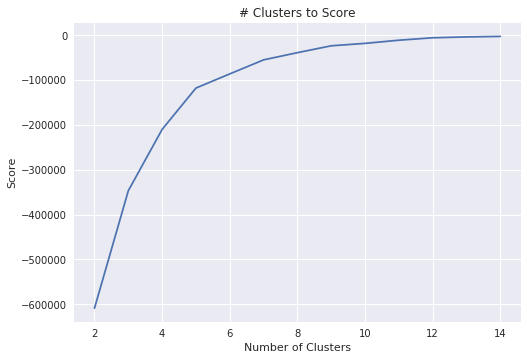

In [151]:
# Investigate the change in within-cluster distance across number of clusters.

vals = sorted(scores.items())
x, y = zip(*vals)
plt.plot(x, y)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('# Clusters to Score')
plt.show()

In [152]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

optim_k = 5
kmeans = KMeans(optim_k)
proc_labels = kmeans.fit_predict(reduced_data)

In [153]:
proc_labels

array([1, 1, 1, ..., 4, 1, 1], dtype=int32)

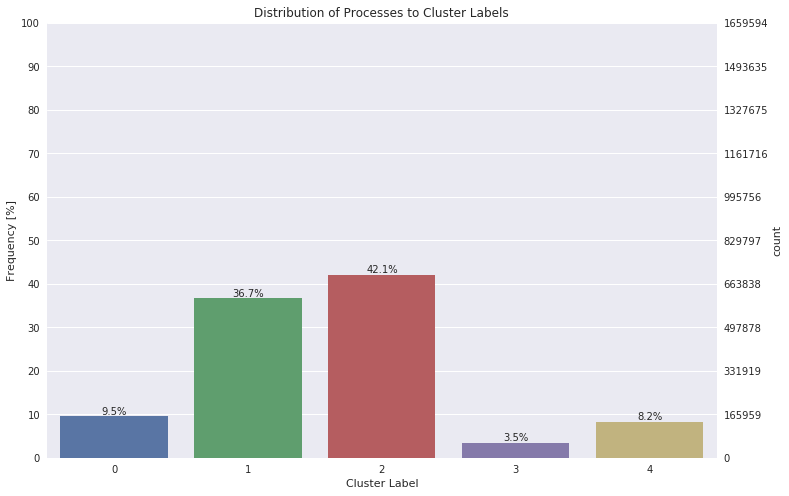

In [159]:
# Cluster label distribution
cluster_df = pd.DataFrame({'proc_labels': proc_labels})

import seaborn as sns
import matplotlib.ticker as ticker

ncount = len(cluster_df)
plt.figure(figsize=(12,8))
ax = sns.countplot(cluster_df['proc_labels'])
plt.title('Distribution of Processes to Cluster Labels')
plt.xlabel('Cluster Label')

# Make twin axis
ax2=ax.twinx()

# Switch so count axis is on right, frequency on left
ax2.yaxis.tick_left()
ax.yaxis.tick_right()

# Also switch the labels over
ax.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('left')

ax2.set_ylabel('Frequency [%]')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text

# Use a LinearLocator to ensure the correct number of ticks
ax.yaxis.set_major_locator(ticker.LinearLocator(11))

# Fix the frequency range to 0-100
ax2.set_ylim(0,100)
ax.set_ylim(0,ncount)

# And use a MultipleLocator to ensure a tick spacing of 10
ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))

# Need to turn the grid on ax2 off, otherwise the gridlines end up on top of the bars
ax2.grid(None)

plt.show()


In [161]:
proc_cluster_data = pd.DataFrame({'PC0':reduced_data[:,0],
                                      'PC1':reduced_data[:,1],
                                      'PC2':reduced_data[:,2],
                                      'PC3':reduced_data[:,3],
                                      'Cluster Label':proc_labels
                                     })

print(proc_cluster_data.describe())

                PC0           PC1           PC2           PC3  Cluster Label
count  1.659594e+06  1.659594e+06  1.659594e+06  1.659594e+06   1.659594e+06
mean  -2.085528e-12 -1.001883e-13 -4.103182e-13  3.687457e-14   1.642849e+00
std    5.020874e-01  4.315276e-01  3.023895e-01  2.915997e-01   9.920326e-01
min   -5.905191e-01 -3.001111e-01 -2.605602e-01 -6.369609e-01   0.000000e+00
25%   -5.905191e-01 -2.935961e-01 -9.745913e-02 -2.701918e-02   1.000000e+00
50%    3.673268e-01 -1.381397e-02 -9.745913e-02 -2.441238e-02   2.000000e+00
75%    3.673268e-01 -1.381397e-02 -7.547211e-02  3.201921e-02   2.000000e+00
max    8.375467e-01  1.737455e+00  9.976878e-01  1.453935e+00   4.000000e+00


In [163]:
for cluster_number in range(5):
    print("Analysis of Cluster ", cluster_number)
    cluster = proc_cluster_data.loc[proc_cluster_data['Cluster Label'] == cluster_number]
    print("Describe:")
    print(cluster.describe())
    print("Centroid:")
    print(kmeans.cluster_centers_[cluster_number])

Analysis of Cluster  0
Describe:
                 PC0            PC1            PC2            PC3  \
count  157705.000000  157705.000000  157705.000000  157705.000000   
mean        0.499347       1.009451      -0.088801      -0.470801   
std         0.419794       0.182946       0.355292       0.175440   
min        -0.198748       0.442338      -0.260560      -0.636961   
25%        -0.148384       0.950846      -0.252566      -0.548688   
50%         0.759098       0.950846      -0.252566      -0.489650   
75%         0.759098       1.230628      -0.230579      -0.489650   
max         0.837547       1.527298       0.842580       0.181039   

       Cluster Label  
count       157705.0  
mean             0.0  
std              0.0  
min              0.0  
25%              0.0  
50%              0.0  
75%              0.0  
max              0.0  
Centroid:
[ 0.4993469   1.00945118 -0.08880113 -0.47080083]
Analysis of Cluster  1
Describe:
                 PC0            PC1          

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


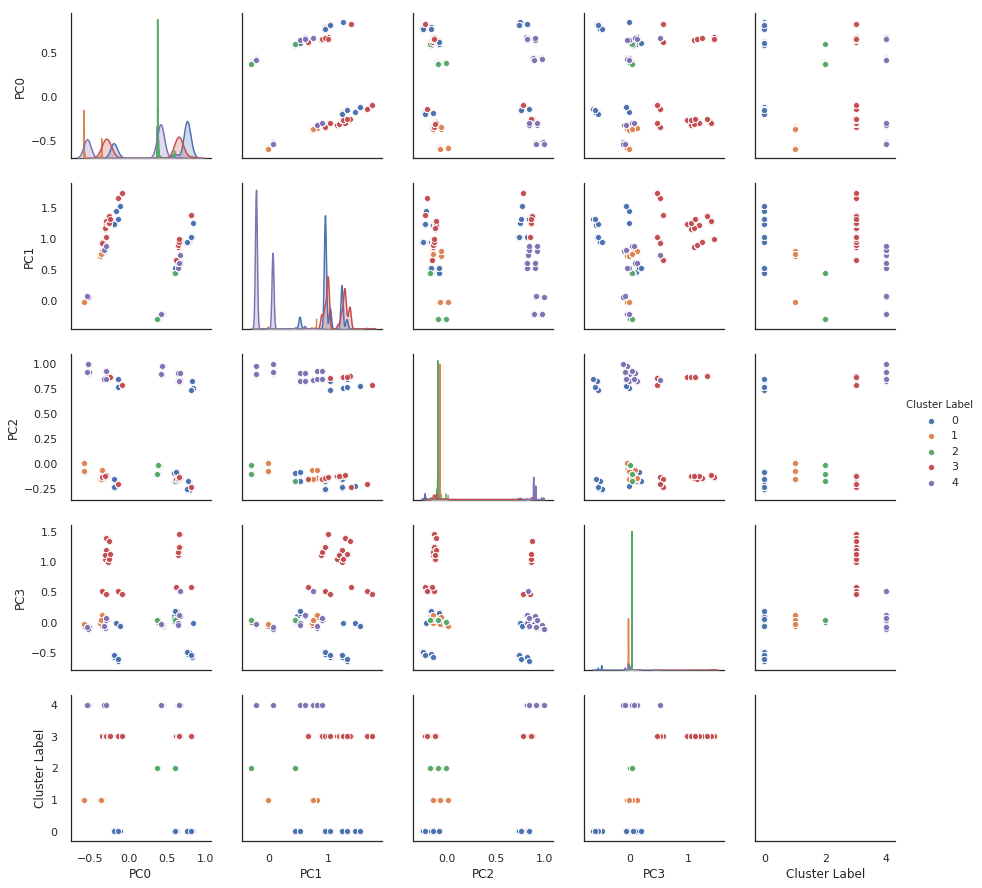

In [165]:
import seaborn as sns
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})
sns.pairplot(proc_cluster_data, hue='Cluster Label')

## UMAP / projection into 2D to view the clusters

In [ ]:
import umap
reducer = umap.UMAP(metric='euclidean')

embedding = reducer.fit_transform(reduced_data)
embedding.shape



In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(proc_labels)
list(le.classes_)

### TODO: Check for multiple users logged in (multiple 4634 events from different users)

Other features to engineer:

* First logon after reboot
* Screensaver on

## WinEvents Overview

In [64]:
disp(md('### _WinEvent DataFrame Summary_'))
pd.options.display.max_columns = None
disp(WE_sample.describe(include="all"))

### _WinEvent DataFrame Summary_

,Unnamed: 0,AuthenticationPackage,Destination,DomainName,EventID,FailureReason,LogHost,LogonID,LogonType,LogonTypeDescription,ParentProcessID,ParentProcessName,ProcessID,ProcessName,ServiceName,Source,Status,SubjectDomainName,SubjectLogonID,SubjectUserName,Time,UserName,minute,5_minutes,30_minutes,hour,Description,recorded_by,after_hours
count,6.635287e+06,2367828,104298,6634920,6.635287e+06,26116,6635287,5702620,3.391273e+06,3391273,1643250,1643250,1853935,1853935,205234,2198400,914195,107312,105596,107312,6.635287e+06,6634954,6.635287e+06,6.635287e+06,6.635287e+06,6.635287e+06,6635287,6635287,6635287
unique,NaN,5,3087,263,NaN,7,10152,3597119,NaN,10,13343,1328,32659,2982,9204,11610,8,55,2102,7426,NaN,20564,NaN,NaN,NaN,NaN,19,3,2
top,NaN,Kerberos,Comp457365,Domain001,NaN,An Error occured during Logon.,ActiveDirectory,0x3e7,NaN,Network,0x364,svchost,0x276c,dllhost.exe,ActiveDirectory$,Comp916004,0x0,Domain001,0x3e7,Administrator,NaN,Comp916004$,NaN,NaN,NaN,NaN,An account was successfully logged on,Comp,False
freq,NaN,1347790,44997,6348565,NaN,10541,2463692,1568264,NaN,3303673,17693,596588,19756,266354,74757,320210,830524,102021,40671,41817,NaN,808494,NaN,NaN,NaN,NaN,1700310,3764853,3686914
mean,3.317643e+06,NaN,NaN,NaN,4.667763e+03,NaN,NaN,NaN,3.050473e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.157579e+05,NaN,7.154876e+02,1.427090e+02,2.337305e+01,1.143860e+01,NaN,NaN,NaN
std,1.915443e+06,NaN,NaN,NaN,5.291328e+01,NaN,NaN,NaN,4.914011e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.301229e+04,NaN,3.835359e+02,7.670638e+01,1.278142e+01,6.388098e+00,NaN,NaN,NaN
min,0.000000e+00,NaN,NaN,NaN,1.100000e+03,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.728000e+05,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN
25%,1.658822e+06,NaN,NaN,NaN,4.624000e+03,NaN,NaN,NaN,3.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.983010e+05,NaN,4.250000e+02,8.500000e+01,1.400000e+01,7.000000e+00,NaN,NaN,NaN
50%,3.317643e+06,NaN,NaN,NaN,4.634000e+03,NaN,NaN,NaN,3.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.160000e+05,NaN,7.200000e+02,1.440000e+02,2.400000e+01,1.200000e+01,NaN,NaN,NaN
75%,4.976464e+06,NaN,NaN,NaN,4.688000e+03,NaN,NaN,NaN,3.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.331850e+05,NaN,1.006000e+03,2.010000e+02,3.300000e+01,1.600000e+01,NaN,NaN,NaN


* 4 main Authentication Packages, disregarding NaN and "-": MSFT_AUTH_V1_0, Kerberos, Negotiate, NTLM
* 7 Failure Reasons - most of these are interesting
* Logon Types/Descriptions are also interesting - Most Prevalent: Network
* Most Prevalent LogHost: ActiveDirectory - Host that Log is talking about
* Most Prevalent Source: Comp916004 - Initiator of Logon Event (same as LogHost for Local Logon)
* Also most Prevalent UserName: Comp916004$ - Computer Specifc Account

In [38]:
# TODO: it would be interesting to cluster the combinations of auth/logon features to see what are common vs anomolies together:
# AuthenticationPackage, FailureReason, LogonTypeDescription, Status

# TODO: is there a set of features that I can predict username from, e.g., using something like RandomForest (supervised), e.g., computer and eventID and hr (drop system)

# EventID